In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 画像を読み込む
ドライブに保存済みの model・weight を読み込む

In [3]:
version = "5th"
f_log = "./log"
f_models = "/content/drive/MyDrive/Colab Notebooks/akimoto/models"
model_filename = f"model_{version}.json"
weight_filename = f"weights_{version}.hdf5"

In [39]:
from keras.models import model_from_json
import os

json_string = open(os.path.join(f_models, model_filename)).read()
model = model_from_json(json_string)

model.summary()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.load_weights(os.path.join(f_models, weight_filename))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                             

## 画像の読み込み

In [59]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))


In [60]:
from PIL import Image
import numpy as np
import glob

IMG_SIZE = 128

labels = ["akb", "saka"]
akb_faces = []
saka_faces = []

test_imgs = glob.glob("/content/drive/MyDrive/Colab Notebooks/akimoto/test_data/*")
for path in test_imgs:
    with Image.open(path) as img:
        # colabでリサイズ
        img = crop_max_square(img)
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

        if "akb" in path or "stu" in path:
            akb_faces.append(np.asarray(img, np.uint8))
        else:
            saka_faces.append(np.asarray(img, np.uint8))

faces = akb_faces + saka_faces
X = (np.array(faces) / 255).astype(np.float32)
# 正解ラベルを作成する
len_faces = len(faces)
len_akb_imgs = len(akb_faces)
len_saka_imgs = len(saka_faces)

y = np.zeros((len_faces, 2))
for j in range(len_akb_imgs):
    y[j, 0] = 1
for k in range(len_saka_imgs):
    y[k+len_akb_imgs, 1] = 1

print(type(X))
print(X.shape)
print(y.shape)

<class 'numpy.ndarray'>
(24, 128, 128, 3)
(24, 2)


## 推論

[[6.09361858e-04 9.99390602e-01]
 [1.96404266e-03 9.98035967e-01]
 [9.85054493e-01 1.49454633e-02]
 [9.99305725e-01 6.94248942e-04]
 [5.24460316e-01 4.75539684e-01]
 [1.72699711e-05 9.99982715e-01]
 [9.99922514e-01 7.75145963e-05]
 [3.55470140e-04 9.99644518e-01]
 [1.01954944e-01 8.98045003e-01]
 [1.03206327e-03 9.98967886e-01]
 [3.98827204e-03 9.96011734e-01]
 [1.18860498e-03 9.98811364e-01]
 [9.84332323e-01 1.56677235e-02]
 [2.18219915e-03 9.97817755e-01]
 [1.25972554e-04 9.99873996e-01]
 [5.28408825e-01 4.71591204e-01]
 [6.86906755e-01 3.13093305e-01]
 [2.14308202e-02 9.78569150e-01]
 [1.10263340e-04 9.99889731e-01]
 [4.61581759e-02 9.53841865e-01]
 [2.28332228e-05 9.99977112e-01]
 [4.47137607e-03 9.95528638e-01]
 [4.12895858e-01 5.87104201e-01]
 [5.17980425e-06 9.99994874e-01]]


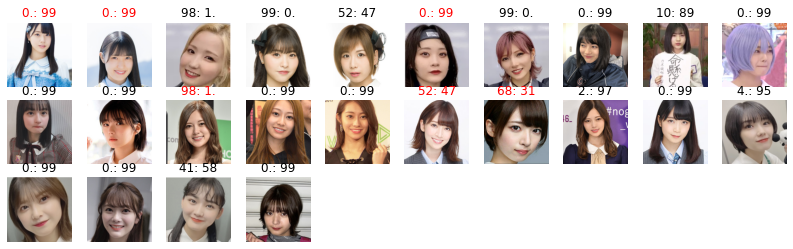

In [61]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,14))
y_raw = model.predict(X)
y_pred = np.argmax(y_raw, axis=-1) # argmaxでラベルを取る
y_correct = np.argmax(y, axis=-1)
print(y_raw)

for i in range(len(test_imgs)):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(X[i])
    ax.axis("off")

    akb_percentage = str(100*y_raw[i][0])[:2]
    saka_percentage = str(100*y_raw[i][1])[:2]
    if y_pred[i] == y_correct[i]:
        ax.set_title(f"{akb_percentage}: {saka_percentage}")
    else:
        ax.set_title(f"{akb_percentage}: {saka_percentage}", color="red")
